In [19]:
%env TF_KERAS=1
import os
import io
import re
import time
import codecs

import tensorflow as tf
import tensorflow.keras as keras
import numpy as np
import matplotlib.pyplot as plt
import MeCab

from keras_bert import load_trained_model_from_checkpoint, Tokenizer, get_pretrained, PretrainedList, get_checkpoint_paths
from matplotlib import rcParams
from sklearn.model_selection import train_test_split

env: TF_KERAS=1


In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

In [3]:
# load file
path_to_file = "./jpn-eng/jpn.txt"

In [4]:
# load bert model
SEQ_LEN = 64
OUTPUT_LAYER_NUM = 4
TRANSFORMER_NUM = 12

model_path = get_pretrained(PretrainedList.multi_cased_base)
PRETRAINED_PATH = get_checkpoint_paths(model_path)
CONFIG_PATH = PRETRAINED_PATH.config
CHECKPOINT_PATH = PRETRAINED_PATH.checkpoint
VOCAB_PATH = PRETRAINED_PATH.vocab

bert_base = load_trained_model_from_checkpoint(
  CONFIG_PATH,
  CHECKPOINT_PATH,
  training=False,
  trainable=False,
  output_layer_num=OUTPUT_LAYER_NUM,
  seq_len=SEQ_LEN
)

In [8]:
# prepare token->idx dictionary
def make_token_dict(vocab_path):
  token_dict = {}
  with codecs.open(vocab_path, 'r', 'utf8') as reader:
    for line in reader:
      if line != ' \n':
        token = line.strip()
      else:
        token = line.strip('\n')
      token_dict[token] = len(token_dict)
  return token_dict

In [5]:
def preprocess_eng_sentence(w):
    w = w.lower().strip()

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.rstrip().strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '[CLS] ' + w + ' [SEP]'
    return w

def preprocess_jpn_sentence(w):
    m = MeCab.Tagger ("-Owakati")
    w = '[CLS] ' + m.parse(w).strip().strip('\n') + ' [SEP]'
    return w

def create_dataset(path, num_examples):
    lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
    eng, jpn = [], []
    for l in lines[:num_examples]:
#         (eng_sentence, jpn_sentence) = l.split('\t')
        (eng_sentence, _) = l.split('\t')
        eng.append(preprocess_eng_sentence(eng_sentence))
#         jpn.append(preprocess_jpn_sentence(jpn_sentence))
    return eng, jpn
  
def max_length(tensor):
    return max(len(t) for t in tensor)

def tokenize(lang):
    # convert words(of a sentence) into word indexes
    lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(
                     filters='')
    lang_tokenizer.fit_on_texts(lang)

    tensor = lang_tokenizer.texts_to_sequences(lang)
    # padding word indexes(of sentences) to the same length(using maximum length of all sentences)
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                           padding='post')

    return tensor, lang_tokenizer

def load_dataset(path, input_vocab_path, num_examples=None, verbose=False):
  # creating cleaned input, output pairs
  targ_lang, _ = create_dataset(path, num_examples)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)

  input_token_dict = make_token_dict(input_vocab_path)
  inp_lang_tokenizer = Tokenizer(input_token_dict, cased=True)
  
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  inp_ids, inp_segments = [], []
  for l in lines[:num_examples]:
      (_, jpn_sentence) = l.split('\t')
      id, segment = inp_lang_tokenizer.encode(jpn_sentence, max_len=SEQ_LEN)
      inp_ids.append(id)
      inp_segments.append(segment)
      if verbose:
        print('{}->{}{}'.format(jpn_sentence, id, segment))

  input_tensor = []
  for i, s in zip(inp_ids, inp_segments):
    input_tensor.append([i,s])        

  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [14]:
# Try experimenting with the size of that dataset
num_examples = 45000
# input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, VOCAB_PATH, num_examples)
input_tensor = np.array(input_tensor)

# Calculate max_length of the target tensors
# max_length_targ, max_length_inp = max_length(target_tensor), max_length(input_tensor)
max_length_targ, max_length_inp = max_length(target_tensor), SEQ_LEN

# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))
print(max_length_targ, max_length_inp)

C:\Users\di.sun\.keras\datasets\multi_cased_L-12_H-768_A-12\vocab.txt
36000 36000 9000 9000
29 64


In [70]:
input_vocab_size = len(make_token_dict(VOCAB_PATH))
target_vocab_size = len(targ_lang.word_index) + 1
print(input_vocab_size, target_vocab_size)

119547 8844


In [69]:
def sum_of_encoder_norm(model, output_layer_num, transformer_num):
  output_layer_num = [-i for i in range(1, output_layer_num + 1)]
  target_layers = []
  for layer_index in output_layer_num:
      if layer_index < 0:
          layer_index = transformer_num + layer_index
      layer_index += 1
      layer = model.get_layer(name='Encoder-{}-FeedForward-Norm'.format(layer_index))
      target_layers.append(layer.output)
  output = keras.layers.add(target_layers)
  return output

In [21]:
inputs = bert_base.inputs[:2]
outputs = sum_of_encoder_norm(bert_base, OUTPUT_LAYER_NUM, TRANSFORMER_NUM)
bert_summed = keras.models.Model(inputs, outputs)

In [23]:
BUFFER_SIZE = input_tensor_train.shape[0]
BATCH_SIZE = 64
steps_per_epoch = input_tensor_train.shape[0]//BATCH_SIZE
# vocab_inp_size = len(inp_lang.word_index)+1
# vocab_tar_size = len(targ_lang.word_index)+1

train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

In [24]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)
  
  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
  
  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
  pos_encoding = angle_rads[np.newaxis, ...]
    
  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 50, 512)


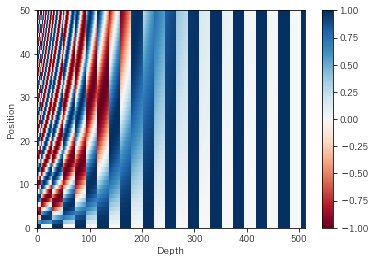

In [25]:
pos_encoding = positional_encoding(50, 512)
print (pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [26]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
  
  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [27]:
x = tf.constant([[7, 6, 0, 0, 1], [1, 2, 3, 0, 0], [0, 0, 0, 4, 5]])
create_padding_mask(x)

<tf.Tensor: id=7708, shape=(3, 1, 1, 5), dtype=float32, numpy=
array([[[[0., 0., 1., 1., 0.]]],


       [[[0., 0., 0., 1., 1.]]],


       [[[1., 1., 1., 0., 0.]]]], dtype=float32)>

In [28]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [29]:
x = tf.random.uniform((1, 3))
temp = create_look_ahead_mask(x.shape[1])
temp

<tf.Tensor: id=7723, shape=(3, 3), dtype=float32, numpy=
array([[0., 1., 1.],
       [0., 0., 1.],
       [0., 0., 0.]], dtype=float32)>

In [30]:
def scaled_dot_product_attention(q, k, v, mask, verbose=False):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead) 
  but it must be broadcastable for addition.
  
  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable 
          to (..., seq_len_q, seq_len_k). Defaults to None.
    
  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
  if verbose:
    print('matmul_qk: {}'.format(matmul_qk))
    
  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
  if verbose:
    print('scaled_attention_logits: {}'.format(scaled_attention_logits))

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [31]:
def print_out(q, k, v, verbose=False):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None, verbose)
  print ('Attention weights are:')
  print (temp_attn)
  print ('Output is:')
  print (temp_out)

In [32]:
np.set_printoptions(suppress=True)

temp_k = tf.constant([[10,0,0],
                      [0,10,0],
                      [0,0,10],
                      [0,0,10]], dtype=tf.float32)  # (4, 3)

temp_v = tf.constant([[   1,0],
                      [  10,0],
                      [ 100,5],
                      [1000,6]], dtype=tf.float32)  # (4, 2)

# This `query` aligns with the second `key`,
# so the second `value` is returned.
temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v, verbose=True)

matmul_qk: [[  0. 100.   0.   0.]]
scaled_attention_logits: [[ 0.       57.735027  0.        0.      ]]
Attention weights are:
tf.Tensor([[0. 1. 0. 0.]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[10.  0.]], shape=(1, 2), dtype=float32)


In [33]:
# This query aligns with a repeated key (third and fourth), 
# so all associated values get averaged.
temp_q = tf.constant([[0, 0, 10]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v, verbose=True)

matmul_qk: [[  0.   0. 100. 100.]]
scaled_attention_logits: [[ 0.        0.       57.735027 57.735027]]
Attention weights are:
tf.Tensor([[0.  0.  0.5 0.5]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[550.    5.5]], shape=(1, 2), dtype=float32)


In [34]:
# This query aligns equally with the first and second key, 
# so their values get averaged.
temp_q = tf.constant([[10, 10, 0]], dtype=tf.float32)  # (1, 3)
print_out(temp_q, temp_k, temp_v, verbose=True)

matmul_qk: [[100. 100.   0.   0.]]
scaled_attention_logits: [[57.735027 57.735027  0.        0.      ]]
Attention weights are:
tf.Tensor([[0.5 0.5 0.  0. ]], shape=(1, 4), dtype=float32)
Output is:
tf.Tensor([[5.5 0. ]], shape=(1, 2), dtype=float32)


In [35]:
# pass all the queries together
temp_q = tf.constant([[0, 0, 10], [0, 10, 0], [10, 10, 0]], dtype=tf.float32)  # (3, 3)
print_out(temp_q, temp_k, temp_v, verbose=True)

matmul_qk: [[  0.   0. 100. 100.]
 [  0. 100.   0.   0.]
 [100. 100.   0.   0.]]
scaled_attention_logits: [[ 0.        0.       57.735027 57.735027]
 [ 0.       57.735027  0.        0.      ]
 [57.735027 57.735027  0.        0.      ]]
Attention weights are:
tf.Tensor(
[[0.  0.  0.5 0.5]
 [0.  1.  0.  0. ]
 [0.5 0.5 0.  0. ]], shape=(3, 4), dtype=float32)
Output is:
tf.Tensor(
[[550.    5.5]
 [ 10.    0. ]
 [  5.5   0. ]], shape=(3, 2), dtype=float32)


In [36]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model
    
    assert d_model % self.num_heads == 0
    
    self.depth = d_model // self.num_heads
    
    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)
    
    self.dense = tf.keras.layers.Dense(d_model)
        
  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])
    
  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]
    
    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)
    
    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)
    
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        
    return output, attention_weights

In [37]:
temp_mha = MultiHeadAttention(d_model=512, num_heads=8)
y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
out, attn = temp_mha(y, k=y, q=y, mask=None)
out.shape, attn.shape

(TensorShape([1, 60, 512]), TensorShape([1, 8, 60, 60]))

In [38]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [39]:
sample_ffn = point_wise_feed_forward_network(512, 2048)
sample_ffn(tf.random.uniform((64, 50, 512))).shape

TensorShape([64, 50, 512])

In [40]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    
  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)
    
    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
    
    return out2

In [41]:
sample_encoder_layer = EncoderLayer(512, 8, 2048)

sample_encoder_layer_output = sample_encoder_layer(
    tf.random.uniform((64, 43, 512)), False, None)

sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

TensorShape([64, 43, 512])

In [42]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model, num_heads)
    self.mha2 = MultiHeadAttention(d_model, num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)
 
    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    
    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)
    
    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
    
    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
    
    return out3, attn_weights_block1, attn_weights_block2

In [43]:
sample_decoder_layer = DecoderLayer(512, 8, 2048)

sample_decoder_layer_output, _, _ = sample_decoder_layer(
    tf.random.uniform((64, 50, 512)), sample_encoder_layer_output, 
    False, None, None)

sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

TensorShape([64, 50, 512])

In [48]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
#     self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(input_vocab_size, self.d_model)
    
    
    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
  
    self.dropout = tf.keras.layers.Dropout(rate)
        
  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]
    
    # adding embedding and position encoding.
#     x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)
    
    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)
    
    return x  # (batch_size, input_seq_len, d_model)

In [51]:
example_input_batch = input_tensor_train[:64]
sample_bert_output = bert_summed.predict([example_input_batch[:, 0, :], example_input_batch[:, 1, :]], batch_size=BATCH_SIZE)

In [71]:
sample_bert_output.shape

(64, 64, 768)

In [72]:
sample_encoder = Encoder(num_layers=2, d_model=768, num_heads=8, 
                         dff=2048, input_vocab_size=input_vocab_size)

sample_encoder_output = sample_encoder(sample_bert_output, 
                                       training=False, mask=None)

print (sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

(64, 64, 768)


In [46]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, 
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    
    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(target_vocab_size, d_model)
    
    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)
    
  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}
    
    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]
    
    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)
      
      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
    
    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [47]:
sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8, 
                         dff=2048, target_vocab_size=8000)

output, attn = sample_decoder(tf.random.uniform((64, 26)), 
                              enc_output=sample_encoder_output, 
                              training=False, look_ahead_mask=None, 
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

(TensorShape([64, 26, 512]), TensorShape([64, 8, 26, 62]))

In [73]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)
    
  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)
    
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)
    
    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
    
    return final_output, attention_weights

In [33]:
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, 
    input_vocab_size=8500, target_vocab_size=8000)

temp_input = tf.random.uniform((64, 62))
temp_target = tf.random.uniform((64, 26))

fn_out, _ = sample_transformer(temp_input, temp_target, training=False, 
                               enc_padding_mask=None, 
                               look_ahead_mask=None,
                               dec_padding_mask=None)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

TensorShape([64, 26, 8000])

In [74]:
num_layers = 6 # 6 in the paper
d_model = 768 # 512 in the paper
dff = 2048 # 2048 in the paper
num_heads = 8

dropout_rate = 0.1

print(input_vocab_size, target_vocab_size)

119547 8844


In [75]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [76]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

Text(0.5, 0, 'Train Step')

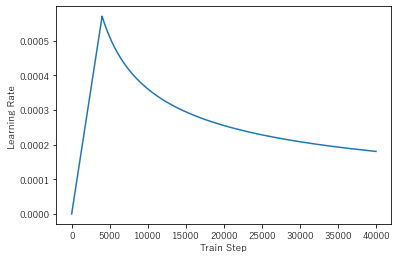

In [77]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [78]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [79]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask
  
  return tf.reduce_mean(loss_)

In [80]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

In [81]:
transformer = Transformer(num_layers, d_model, num_heads, dff,
                          input_vocab_size, target_vocab_size, dropout_rate)

In [82]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)
  
  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)
  
  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
  
  return enc_padding_mask, combined_mask, dec_padding_mask

In [83]:
checkpoint_path = "./transformer_checkpoints"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
# if ckpt_manager.latest_checkpoint:
#   ckpt.restore(ckpt_manager.latest_checkpoint)
#   print ('Latest checkpoint restored!!')

In [103]:
enc_padding_mask, combined_mask, dec_padding_mask = create_masks(input_tensor_train[:64, 0, :], target_tensor_train[:64, :-1])

predictions, _ = transformer(bert_embedding, target_tensor_train[:64, :-1], 
                             True, 
                             enc_padding_mask, 
                             combined_mask, 
                             dec_padding_mask)

In [105]:
predictions.shape

TensorShape([64, 28, 8844])

In [101]:
EPOCHS = 20

# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64), # care default length of integer
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

# @tf.function(input_signature=train_step_signature)
@tf.function
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]
  print(inp.shape, tar.shape)
  enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp[:, 0, :], tar_inp)
  
  with tf.GradientTape() as tape:
    bert_embedding = bert_summed.predict([inp[:, 0, :], inp[:, 1, :]], steps=1)
    predictions, _ = transformer(bert_embedding, tar_inp, 
                                 True, 
                                 enc_padding_mask, 
                                 combined_mask, 
                                 dec_padding_mask)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)    
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
  
  train_loss(loss)
  train_accuracy(tar_real, predictions)

In [102]:
for epoch in range(EPOCHS):
  start = time.time()
  
  train_loss.reset_states()
  train_accuracy.reset_states()
  
  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_dataset):
    train_step(inp, tar)
    
    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
          epoch + 1, batch, train_loss.result(), train_accuracy.result()))
      
  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))
    
  print ('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1, 
                                                train_loss.result(), 
                                                train_accuracy.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

(64, 2, 64) (64, 29)


AttributeError: in converted code:

    <ipython-input-101-f454119363dd>:23 train_step  *
        bert_embedding = bert_summed.predict([inp[:, 0, :], inp[:, 1, :]], steps=1)
    C:\Users\di.sun\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training.py:915 predict
        use_multiprocessing=use_multiprocessing)
    C:\Users\di.sun\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training_arrays.py:722 predict
        callbacks=callbacks)
    C:\Users\di.sun\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\keras\engine\training_arrays.py:299 model_iteration
        batch_outs = f(actual_inputs)
    C:\Users\di.sun\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\keras\backend.py:3633 __call__
        [x._numpy() for x in outputs],  # pylint: disable=protected-access
    C:\Users\di.sun\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow_core\python\keras\backend.py:3633 <listcomp>
        [x._numpy() for x in outputs],  # pylint: disable=protected-access

    AttributeError: 'Tensor' object has no attribute '_numpy'


In [44]:
def evaluate(inp_sentence, verbose=False):
  inp_sentence = preprocess_jpn_sentence(inp_sentence)
  
  inputs = [inp_lang.word_index[i] for i in inp_sentence.split(' ')]
  
  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
  
  inputs = tf.convert_to_tensor(inputs)
    
#   encoder_input = tf.expand_dims(inputs, 0)
  encoder_input = inputs
  if verbose:
    print('encoder_input: {} {}'.format(encoder_input, encoder_input.shape))
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [targ_lang.word_index['<start>']]
  output = tf.expand_dims(decoder_input, 0)
  if verbose:
    print('initial output: {} {}'.format(output, output.shape))
    
  for i in range(max_length_targ):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
    if verbose:
      print(enc_padding_mask, '\n', combined_mask, '\n', dec_padding_mask)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if targ_lang.index_word[int(predicted_id)] == '<end>':
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [73]:
def plot_attention_weights(attention, sentence, result, layer):
  fig = plt.figure(figsize=(48, 24))
  
  sentence = preprocess_jpn_sentence(sentence)
  sentence = [inp_lang.word_index[i] for i in sentence.split(' ')]
#   sentence = tokenizer_pt.encode(sentence)
  
  attention = tf.squeeze(attention[layer], axis=0)
  
  for head in range(attention.shape[0]):
    ax = fig.add_subplot(8, 1, head+1)
    
    # plot the attention weights
    ax.matshow(attention[head][:-1, :len(sentence)], cmap='viridis')

    fontdict = {'fontsize': 16}

    ax.set_xticks(range(len(sentence)))
    ax.set_yticks(range(len(result)))
    
    ax.set_ylim(len(result)-1.5, -0.5)
        
    ax.set_xticklabels(
        [inp_lang.index_word[i] for i in sentence], 
        fontdict=fontdict, rotation=90)
    
    ax.set_yticklabels([targ_lang.index_word[i] for i in result], 
                       fontdict=fontdict)
    
    ax.set_xlabel('Head {}'.format(head+1))
  
  plt.tight_layout()
  plt.show()

In [74]:
def translate(sentence, plot='', verbose=False):
  result, attention_weights = evaluate(sentence, verbose=verbose)
  
  result = result.numpy()
  predicted_sentence = ''
  for x in result:
    predicted_sentence += targ_lang.index_word[x]
    predicted_sentence += ' '

  print('Input: {}'.format(sentence))
  print('Predicted translation: {}'.format(predicted_sentence))
  
  if plot:
    plot_attention_weights(attention_weights, sentence, result, plot)

In [76]:
test = '外は雪ですね。'
# translate(test, plot='decoder_layer6_block2', verbose=False)
translate(test, plot='', verbose=False)

Input: 外は雪ですね。
Predicted translation: <start> it s snowing outside . 


In [90]:
translate('助けが必要です。', plot='', verbose=False)

Input: 助けが必要です。
Predicted translation: <start> i need help . 


In [52]:
translate('いい天気ですね。', plot='', verbose=False)

Input: いい天気ですね。
Predicted translation: <start> it s a nice day . 


In [ ]:
translate('どうすればいいでしょうか？', plot='decoder_layer6_block2', verbose=False)

In [54]:
translate('釣りにいきませんか？', plot='', verbose=False)

Input: 釣りにいきませんか？
Predicted translation: <start> don t you go fishing ? 


In [55]:
translate('教科書を見てください。', plot='', verbose=False)

Input: 教科書を見てください。
Predicted translation: <start> please look at the right . 


In [ ]:
# import matplotlib.font_manager as fm
# fm.findSystemFonts()

In [116]:
print(len(inp_lang.word_index))
print(input_vocab_size, target_vocab_size)

13824
13827 8846


In [91]:
a = train_dataset.batch(1).take(1)

In [150]:
def fetch(a):
  for inp, targ in a:
    return inp[0,0,:], targ[0,0,:]
inp_test, targ_test = fetch(a)

In [151]:
print(inp_test, targ_test)

tf.Tensor(
[   1 7009    4   95   10 5589   20    3    2    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0], shape=(44,), dtype=int32) tf.Tensor(
[   1 4911   34   14  576 2783   92    3    2    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0], shape=(29,), dtype=int32)


In [158]:
def test_func(inp):

  encoder_input = tf.expand_dims(inp, 0)
  print('encoder_input: {} {}'.format(encoder_input, encoder_input.shape))
  
  # as the target is english, the first word to the transformer should be the
  # english start token.
  decoder_input = [targ_lang.word_index['<start>']]
  output = tf.expand_dims(decoder_input, 0)
  print('initial output: {} {}'.format(output, output.shape))
    
  for i in range(max_length_targ):
    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(
        encoder_input, output)
    print(enc_padding_mask, '\n', combined_mask, '\n', dec_padding_mask)
  
    # predictions.shape == (batch_size, seq_len, vocab_size)
    predictions, attention_weights = transformer(encoder_input, 
                                                 output,
                                                 False,
                                                 enc_padding_mask,
                                                 combined_mask,
                                                 dec_padding_mask)
    
    # select the last word from the seq_len dimension
    predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)

    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
    
    # return the result if the predicted_id is equal to the end token
    if targ_lang.index_word[int(predicted_id)] == '<end>':
      return tf.squeeze(output, axis=0), attention_weights
    
    # concatentate the predicted_id to the output which is given to the decoder
    # as its input.
    output = tf.concat([output, predicted_id], axis=-1)

  return tf.squeeze(output, axis=0), attention_weights

In [ ]:
o = test_func(inp_test)

In [165]:
o = o[0].numpy()
print(o)
for i in o:
  print(targ_lang.index_word[i])

[  1  77 255 208  49  40  15 350  13   8   9]
<start>
so
since
ever
will
be
,
aren
t
you
?
